[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drdave-teaching/OPIM5509Files/blob/main/OPIM5509_Module4_Files/Univariate_Temperature_RNN.ipynb)

# Univariate Temperature Example (RNN)
-------------------------

**Dr. Dave Wanik - University of Connecticut**

Let's see if we can predict the next day's temperature as a function of N previous days.

Each of these is an example of a many-to-one classification (using a single feature with a lookback of N). This is the among the most tasks that need to be done with time series problems.

You could also try to implement a one-to-one by simply shifting the column by -1 then re-running (this is different than the baseline model we show at the end).

In [ ]:
# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RNN-specific modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM
from tensorflow.keras.callbacks import EarlyStopping

## Read in data
Check for missing values, make some plots.

In [ ]:
# read the data
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
df = pd.read_csv(url)
print(df.info())
df.head(n=15) # nice complete data! this will allow us to check our work later

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB
None


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
5,1981-01-06,15.8
6,1981-01-07,15.8
7,1981-01-08,17.4
8,1981-01-09,21.8
9,1981-01-10,20.0


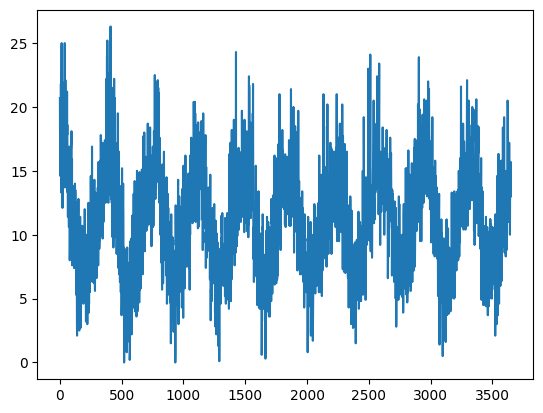

In [ ]:
# visualize the data
df['Temp'].plot()
plt.show()

In [ ]:
# prep data for modeling (univariate)
# link: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
# here's an example of how this script works
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90


In [ ]:
# all we need to do is decide on is n_steps (what our lookback period is)
# since we have a bunch of data, why not n_steps=10? then try 30 later on.
n_steps = 10
raw_seq = df['Temp'] # the second column, where the data is. UPDATE THIS ON YOUR DATA!
# let's ignore the date column and just use the temperature data
X, y = split_sequence(raw_seq, n_steps)

In [ ]:
# check out X and y shape
print(df.shape)
print(X.shape)

(3650, 2)
(3640, 10)


In [ ]:
# take a peak at what it did
print(X[0])
print(y[0])

# scroll up and make sure you understand this!
# y is a function of X (the previous n_steps observations!)

[20.7 17.9 18.8 14.6 15.8 15.8 15.8 17.4 21.8 20. ]
16.2


In [ ]:
# now we reshape the data into a 3D array
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1 # this is 1 because it is univariate data
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(3640, 10, 1)

In [ ]:
# split the data into train and test partitions
# we will use 90% of the data for train, and 10% for validation
train_pct_index = int(0.9 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# pretty slick way of splitting your data using slicing!
# notice how we didn't do any shuffling (we don't want temporal leakage! keeps time series intact)

In [ ]:
# check the shape to be sure
print(X.shape, X_train.shape, X_test.shape)

# verify that this all adds up!

(3640, 10, 1) (3276, 10, 1) (364, 10, 1)


In [ ]:
# peak at it!
X_train[0]

array([[20.7],
       [17.9],
       [18.8],
       [14.6],
       [15.8],
       [15.8],
       [15.8],
       [17.4],
       [21.8],
       [20. ]])

In [ ]:
y[0]

16.2

In [ ]:
# if we wanted to, we could do some scaling/normalization here, would not hurt!

# RNN one layer model

In [ ]:
# samples, lookback, features
# samples = original rows in df - lookback period
# 3640 = 3650 - 10
X.shape

(3640, 10, 1)

In [ ]:
# store these features for modeling
n_features = X.shape[2]
n_steps = X.shape[1]

print(n_steps, n_features)

10 1


In [ ]:

# now let's build a model

# since this is a univariate problem, n_features will be 1 (we also defined this before, but this is a better way)
n_features = X.shape[2] # 1 green dot
n_steps = X.shape[1] # 10 steps (not shown in the animation - this is how many times it loops)

# define model
model = Sequential()
model.add(SimpleRNN(30, input_shape=(n_steps,n_features), activation='relu')) # 30 red dots
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=500,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the train data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30)                960       
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 991 (3.87 KB)
Trainable params: 991 (3.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
524/524 [==============================] - 10s 14ms/step - loss: 6.6459 - mae: 2.0401 - val_loss: 5.7137 - val_mae: 1.8976
Epoch 2/500
524/524 [==============================] - 3s 6ms/step - loss: 6.3400 - mae: 1.9922 - val_loss: 5.5056 - val_mae: 1.8665
Epoch 3/500
524/524 [==============================] - 2s 4ms/step - loss: 6.2973 - mae: 1.9676 - val_loss: 5.5445 - val_mae: 1.8697
Epoch 4/500
524/524 [

12/12 [==============================] - 0s 2ms/step
MAE:  1.769710869841523


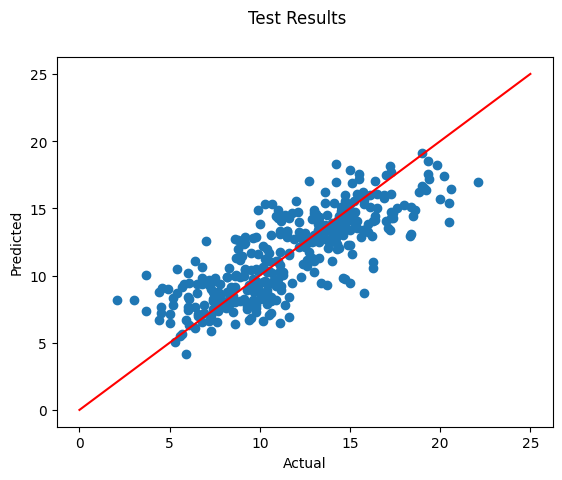

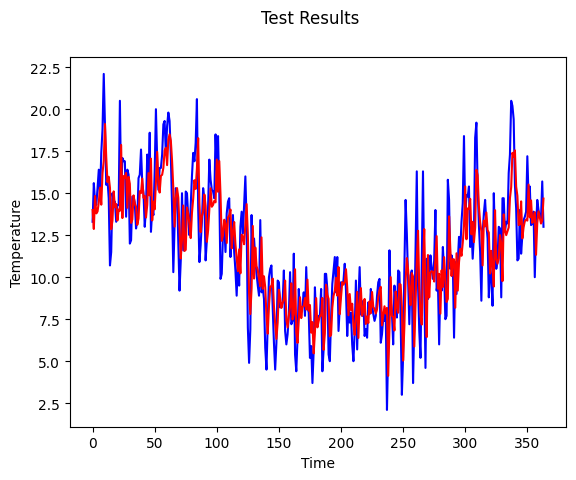

In [ ]:
# show scatterplots of actual vs. predicted for train and test
# make a prediction
pred = model.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, pred))

actual = y_test # the actual
plt.scatter(x=actual, y=pred)
x = np.linspace(0,25) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

## On your own: add the learning curve and the train results!

# LSTM one layer model
Literally, just grab the code above and change SimpleRNN to LSTM and boom! you have a more sophisticated model.

In [ ]:
# now let's build a model

# since this is a univariate problem, n_features will be 1 (we also defined this before)
n_features = X.shape[2] # 1 green dot = 1 feature
n_steps = X.shape[1] # these are time steps = there are 10!

# define model
model = Sequential()
model.add(LSTM(30, input_shape=(n_steps,n_features), activation='relu')) # 30 red dots = hidden size of 30
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=500,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30)                3840      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 3871 (15.12 KB)
Trainable params: 3871 (15.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
524/524 [==============================] - 4s 6ms/step - loss: 19.2812 - mae: 2.9473 - val_loss: 5.8338 - val_mae: 1.9045
Epoch 2/500
524/524 [==============================] - 3s 6ms/step - loss: 6.4101 - mae: 1.9848 - val_loss: 5.4680 - val_mae: 1.8542
Epoch 3/500
524/524 [==============================] - 4s 8ms/step - loss: 6.3273 - mae: 1.9598 - val_loss: 5.3459 - val_mae: 1.8274
Epoch 4/500
524/

12/12 [==============================] - 0s 3ms/step
MAE:  1.7428520904792535


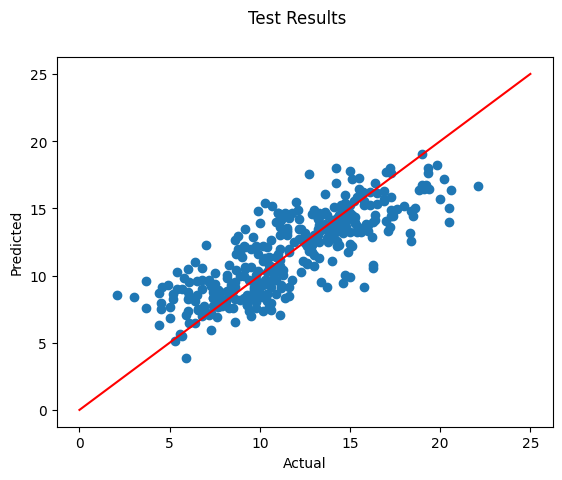

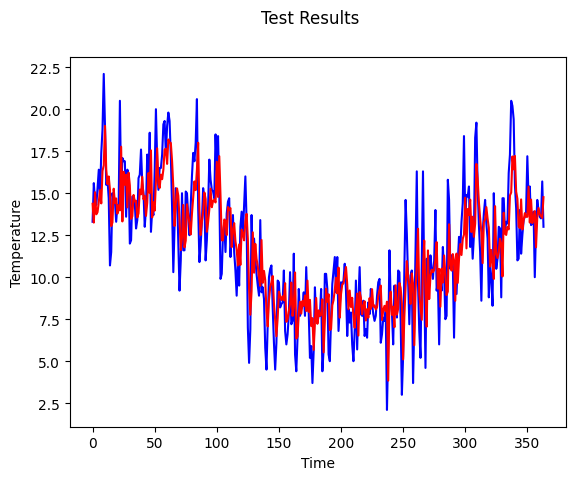

In [ ]:
# show scatterplots of actual vs. predicted for train and test
# make a prediction
pred = model.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, pred))

actual = y_test # the actual
plt.scatter(x=actual, y=pred)
x = np.linspace(0,25) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

# Baseline Model
What if you just use yesterday's value as the prediction?!

In [ ]:
# baseline model - prediction is just the previous time step (a tough one to beat!)
df['Baseline'] = df['Temp'].shift(1)
df.head()

,Date,Temp,Baseline
0,1981-01-01,20.7,NaN
1,1981-01-02,17.9,20.7
2,1981-01-03,18.8,17.9
3,1981-01-04,14.6,18.8
4,1981-01-05,15.8,14.6


In [ ]:
# if you wanted to see how this model does, use df['Baseline'] for the pred
# here's how I'd do it
y_test_baseline = df['Baseline'].tail(y_test.shape[0])
# check your work
y_test_baseline.shape

(364,)

In [ ]:
# check shapes, looks good!
y_test.shape

(364,)

MAE:  2.0247252747252746


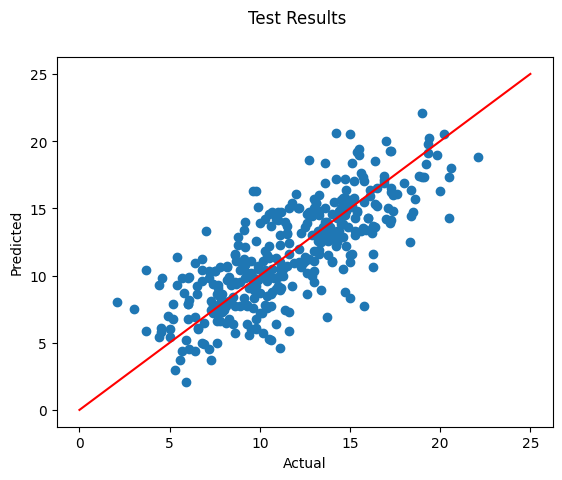

In [ ]:
# now set this equal to pred and repeat code!



# show scatterplots of actual vs. predicted for train and test
# make a prediction
pred = y_test_baseline # the pred
actual = y_test # the actual

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, pred))


plt.scatter(x=actual, y=pred)
x = np.linspace(0,25) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

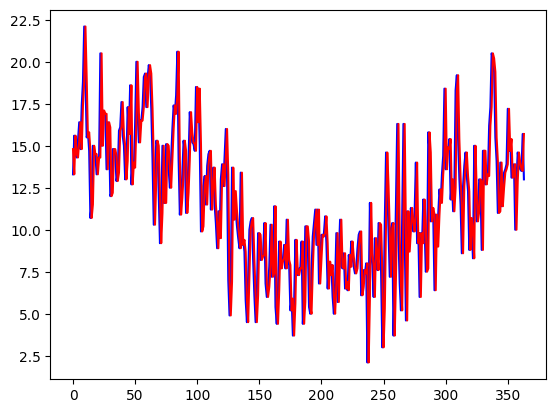

In [ ]:
# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.show()
# looks good, BUT it's not a smart model! all the data is just shifted.

In [ ]:
# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, pred)

2.0247252747252746

In [ ]:
# our RNN models beats the baseline model!
# don't be FOOLED by the line plot... or model is 20% better than a dumb model!